In [1]:
import pandas as pd
import glob
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", module="matplotlib")

In [2]:
feature_dict_names = {'mtDNA_dosage_norm':'mtDNA copy number', '5S_dosage_norm':'5S rDNA copy number', 
                      '18S_dosage_norm':'18S rDNA copy number', '28S_dosage_norm':'28S rDNA copy number', 
                      '45S_dosage_norm':'45S rDNA copy number', 'n_fungi_norm':'fungal load', 
                      'n_microbiome_norm':'microbial load', 'n_protozoa_norm':'protozoa load', 
                      'n_viral_norm':'viral load', 'loadIG_ligth_chain_norm':'IG κ and λ infiltration', 
                      'loadIG_norm':'BCR infiltration', 'loadIGH_norm':'IGH infiltration', 
                      'loadIGK_norm':'IG κ infiltration', 'loadIGL_norm':'IG λ infiltration', 
                      'loadTCR_norm':'T cell infiltration', 'loadTCRA_norm':'T cell α infiltration', 
                      'loadTCRB_norm':'T cell β infiltration', 'loadTCRD_norm':'T cell δ infiltration',
                      'loadTCRG_norm':'T cell γ infiltration', 'nIG_ligth_chain_norm':'IG κ and λ richness', 
                      'nIG_norm':'BCR richness', 'nIGH_norm':'IGH richness', 'nIGK_norm':'IG κ richness', 
                      'nIGL_norm':'IG λ richness', 'nTCR_norm':'TCR richness', 'nTCRA_norm':'TCR α richness', 
                      'nTCRB_norm':'TCR β richness', 'nTCRD_norm':'TCR δ richness', 'nTCRG_norm':'TCR γ richness',
                      'alphaIGH':'IGH Shannon', 'alphaIGK':'IG κ Shannon', 'alphaIGL':'IG λ Shannon', 
                      'alphaTCRA':'TCR α Shannon', 'alphaTCRB':'TCR β Shannon', 'alphaTCRD':'TCR δ Shannon', 
                      'alphaTCRG':'TCR γ Shannon'}

In [3]:

def compute_frequency(data, chain_types, directory_csvs):

    samples = data['Sample ID']

    for chain_type in chain_types:

        dict={}

        for s in samples:
            dict[s]={}
            dict[s]['true'] = pd.DataFrame()
            dict[s]['wxs'] = pd.DataFrame()
            dict[s]['true.wxs'] = pd.DataFrame()


        for root, dirs, files in os.walk(directory_csvs):
            for file in files:
                for s in samples:
                    if s in file:
                        if file.endswith('_rna_'+chain_type+'.csv'):
                            dict[s]['true'] = pd.read_csv(directory_csvs+file)
                            dict[s]['true'] = dict[s]['true'].rename(columns={'relative.frequency': 'FREQ'})

                        if file.endswith('_wxs_'+chain_type+'.csv'):
                            dict[s]['wxs'] = pd.read_csv(directory_csvs+file)
                            dict[s]['wxs'] = dict[s]['wxs'].rename(columns={'relative.frequency': 'FREQ.wxs'})
                            dict[s]['wxs'] = dict[s]['wxs'].rename(columns={'count': 'count.wxs'})

        for s in samples:

            if dict[s]['wxs'].size == 0:
                dict[s]['true.wxs'] = pd.DataFrame()

            if dict[s]['true'].size!=0 and dict[s]['wxs'].size!=0:

                dict[s]['true.wxs']=pd.merge( dict[s]['true'], dict[s]['wxs'], on='CDR3') #wxs and true


        file = open('../summary_data/imrep_tcga-luad/clonotype_frequency_'+chain_type+'.csv',"w")
        
        file.write("th,wxs_portion_frequency\n")


        for th in np.linspace(0., 1.0, 1000):

            s_portions = []

            for s in samples: 

                k_wxs=0
                k_true=0

                s_wxs=0
                s_true=0


                if dict[s]['true.wxs'].size != 0:

                    freq_local_wxs = dict[s]['true.wxs']['FREQ']

                    for freq in  freq_local_wxs:

                        if freq >= th:
                            k_wxs += 1.0    #number of clonotypes with frequency greater or equal than th
                            s_wxs += freq   #sum of frequencies of RNA greater or equal than th


                if dict[s]['true'].size != 0:

                    freq_local_true = dict[s]['true']['FREQ']

                    for freq in freq_local_true:

                        if freq >= th:
                            k_true += 1.0 #number of clonotypes with frequency greater or equal than th
                            s_true += freq #sum of frequencies of RNA greater or equal than th

                if s_true == 0:
                    s_true = 1

                if k_wxs > 0:

                    s_portion=(s_wxs/s_true)
                    s_portions.append(s_portion)

            file.write(str(th)+","+str(np.mean(s_portions))+"\n")

        file.close()

    print("done")

# TCGA - Computing frequencies
## Set the variable generate_summaries to True if you need to compute the summaries

In [9]:
data = {}

data_rna = pd.read_csv('../summary_data/sbt_features_tcga-luad_rna.csv')
data_wxs = pd.read_csv('../summary_data/sbt_features_tcga-luad_wxs.csv')


#RNA
data['rna'] = pd.DataFrame(columns = ['filename', 'File Name'])

mylist = [f for f in glob.glob("../summary_data/imrep_tcga-luad/cdr3_rna/*cdr3")]

for name in mylist:
    rna_name=os.path.basename(name)[:36]
    data['rna'] = data['rna'].append({'filename':os.path.basename(name),'File Name': rna_name }, ignore_index=True)

data['rna'] = data['rna'].merge(data_rna, on='File Name', suffixes=(False, False))

#WXS                                         
data['wxs'] = pd.DataFrame(columns = ['filename', 'File Name'])

mylist = [f for f in glob.glob("../summary_data/imrep_tcga-luad/cdr3_wxs/*cdr3")]

for name in mylist:
    wxs_name = os.path.basename(name)[:36]
    data['wxs'] = data['wxs'].append({'filename':os.path.basename(name),'File Name':wxs_name  }, ignore_index=True)
    
data['wxs'] = data['wxs'].merge(data_wxs, on='File Name', suffixes=(False, False))

result  = data['wxs'].merge(data['rna'], on='Sample ID', suffixes=('_wxs', '_rna'))


samples = result['Sample ID']

chain_types = ['IGH','IGL','IGK','TRA','TRB','TRD','TRG']

directory_csvs="../summary_data/imrep_tcga-luad/summaries/"


generate_summaries = False

if generate_summaries:
    
    chain_types = ['IGH','IGL','IGK','TRA','TRB','TRD','TRG']

    with open("../summary_data/imrep_tcga-luad/clonotype_count_rna.txt", "w") as out_file:

        out_file.write("Sample ID,chain_type,rna_count\n")

        for index, row in data['rna'].iterrows():

            key = row['Sample ID']

            rna_file = "../summary_data/imrep_tcga-luad/cdr3_rna/"+row['filename']

            rna = pd.read_csv(rna_file)


            for chain_type in chain_types:       

                rna_chain = rna.loc[rna['Chain_type'] == chain_type, ['CDR3_AA_Seq','Read_count']] 
                if  rna_chain.shape[0] > 0:
                    rna_chain = rna_chain.groupby(['CDR3_AA_Seq'], as_index=False)['Read_count'].sum()
                    count = rna_chain['Read_count'].sum()
                    rna_chain['relative.frequency'] = rna_chain['Read_count']/count
                    rna_chain = rna_chain.rename(columns={'CDR3_AA_Seq': "CDR3"}, errors="raise")
                    rna_chain = rna_chain.rename(columns={'Read_count': "count"}, errors="raise")    
                else:
                    rna_chain  = pd.DataFrame(columns = ['CDR3', 'relative.frequency', 'count'])

                rna_chain.to_csv("../summary_data/imrep_tcga-luad/summaries/"+key+"_rna_"+chain_type+".csv", index= False)
                rna_count = rna_chain.shape[0]

                out_file.write(key+","+chain_type+","+str(rna_count)+"\n")

    with open("../summary_data/imrep_tcga-luad/clonotype_count_wxs.txt", "w") as out_file:

        out_file.write("Sample ID,chain_type,wxs_count\n")
        print(data['wxs'].shape)

        for index, row in data['wxs'].iterrows():

            key = row['Sample ID']

            wxs_file = "../summary_data/imrep_tcga-luad/cdr3_wxs/"+row['filename']

            wxs = pd.read_csv(wxs_file)


            for chain_type in chain_types:       

                wxs_chain = wxs.loc[wxs['Chain_type'] == chain_type, ['CDR3_AA_Seq','Read_count']] 
                if  wxs_chain.shape[0] > 0:
                    wxs_chain = wxs_chain.groupby(['CDR3_AA_Seq'], as_index=False)['Read_count'].sum()
                    count = wxs_chain['Read_count'].sum()
                    wxs_chain['relative.frequency'] = wxs_chain['Read_count']/count
                    wxs_chain = wxs_chain.rename(columns={'CDR3_AA_Seq': "CDR3"}, errors="raise")
                    wxs_chain = wxs_chain.rename(columns={'Read_count': "count"}, errors="raise")    
                else:
                    wxs_chain  = pd.DataFrame(columns = ['CDR3', 'relative.frequency', 'count'])

                wxs_chain.to_csv("../summary_data/imrep_tcga-luad/summaries/"+key+"_wxs_"+chain_type+".csv", index= False)
                wxs_count = wxs_chain.shape[0]

                out_file.write(key+","+chain_type+","+str(wxs_count)+"\n")

compute_frequency(result, chain_types,  directory_csvs)

done


# Figure S6

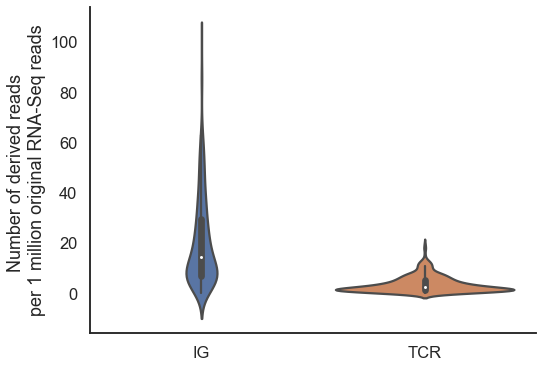

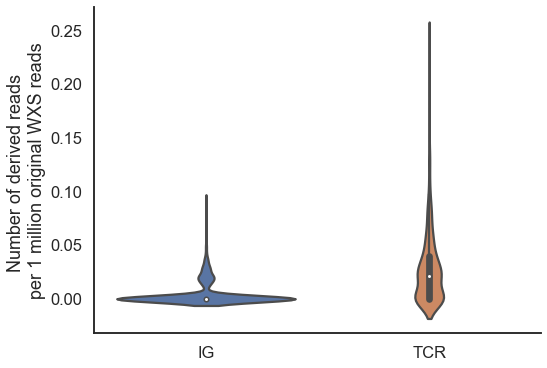

In [5]:
data_rna = pd.read_csv('../summary_data/sbt_features_tcga-luad_rna.csv')
data_wxs = pd.read_csv('../summary_data/sbt_features_tcga-luad_wxs.csv')

clonotype_count_wxs = pd.read_csv("../summary_data/imrep_tcga-luad/clonotype_count_wxs.txt")
clonotype_count_rna = pd.read_csv("../summary_data/imrep_tcga-luad/clonotype_count_rna.txt")

clonotype_count = clonotype_count_wxs.merge(clonotype_count_rna, on=['Sample ID','chain_type'])


clonotype_count = clonotype_count.merge(data_rna, left_on='Sample ID', right_on='Sample ID', suffixes=(False, False))
clonotype_count = clonotype_count.merge(data_wxs, left_on='Sample ID', right_on='Sample ID', suffixes=("_rna","_wxs"))

clonotype_count['rna_count_CPM'] = clonotype_count['rna_count']/clonotype_count['#reads_rna']*1000000
clonotype_count['wxs_count_CPM'] = clonotype_count['wxs_count']/clonotype_count['#reads_wxs']*1000000

clonotype_count.loc[clonotype_count['chain_type'].str.contains('IG'),'chain_group']='IG'
clonotype_count.loc[clonotype_count['chain_type'].str.contains('TR'),'chain_group']='TCR'


clonotype_count_agrr = clonotype_count.groupby(['Sample ID','chain_group'])[['rna_count_CPM', 'wxs_count_CPM']].sum().reset_index()

sns.set(font_scale = 2)
sns.set_style("white")
sns.set_context("talk")

data_ = clonotype_count_agrr.loc[clonotype_count_agrr['chain_group'] == "TCR",]

fig, ax1 = plt.subplots(figsize=(8, 6))
sns.violinplot(x="chain_group", y="rna_count_CPM", data=clonotype_count_agrr, ax=ax1)
plt.ylabel("Number of derived reads \nper 1 million original RNA-Seq reads")
plt.xlabel("")
sns.despine()

plt.savefig("../figures/FigS6a_derived_reads_tcga-luad.png", bbox_inches='tight')
plt.show()

fig, ax1 = plt.subplots(figsize=(8, 6))
sns.violinplot(x="chain_group", y="wxs_count_CPM", data=clonotype_count_agrr, ax=ax1)
plt.ylabel("Number of derived reads \nper 1 million original WXS reads")
plt.xlabel("")
sns.despine()

plt.savefig("../figures/FigS6b_derived_reads_tcga-luad.png", bbox_inches='tight')
plt.show()

# Figure S7

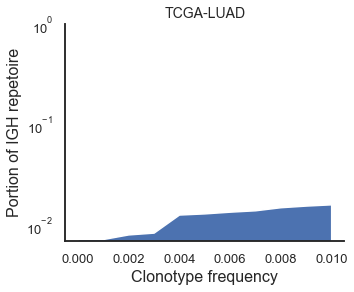

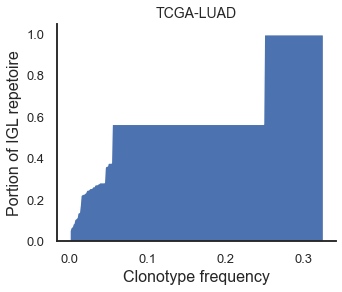

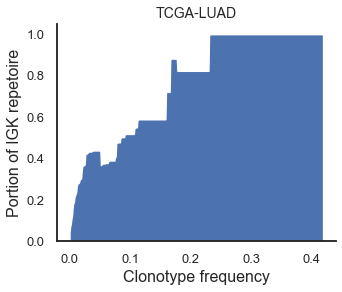

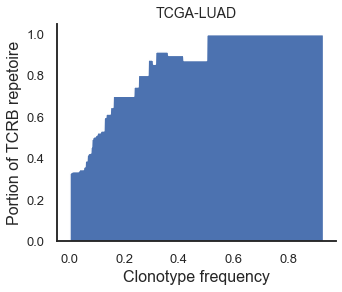

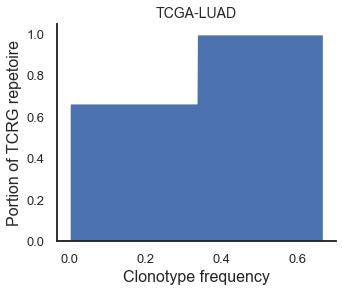

In [6]:

chain_types = ['IGH','IGL','IGK','TRB','TRG']
label = {'IGH':'IGH','IGL':'IGL','IGK':'IGK','TRA':'TCRA','TRB':'TCRB','TRD':'TCRD','TRG':'TCRG'}
letters = {'IGH':'a','IGL':'b','IGK':'c','TRB':'d','TRG':'e'}

axis_font = {'fontname':'Arial', 'size':'14'}

for chain_type in chain_types:
    
    fig, ax1 = plt.subplots(figsize=(5, 4))
       
    data1=pd.read_csv('../summary_data/imrep_tcga-luad/clonotype_frequency_'+chain_type+'.csv')
    data2=pd.read_csv('../summary_data/imrep_tcga-luad/clonotype_frequency_'+chain_type+'.csv')


    a = data1.loc[data1['th'] > 0.10]
    
    ax1.stackplot(data1['th'], data1['wxs_portion_frequency'])
    
    locs, labels = plt.xticks()
    ax1.set_ylabel('Portion of '+label[chain_type]+' repetoire')
    ax1.set_xlabel('Clonotype frequency')
    ax1.set_title("TCGA-LUAD",**axis_font)
    
    # setting label sizes after creation
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
       
    
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax1.tick_params(axis='both', which='minor', labelsize=13)
   
    sns.despine()
    plt.subplots_adjust(wspace=0.5)
    
    if chain_type == 'IGH' or chain_type == 'TRA':
        plt.yscale('log')
        plt.ylim(0,1)

    
    plt.savefig("../figures/FigS7"+letters[chain_type]+"_clonotype_frequency_tcga-luad_"+chain_type+".png", bbox_inches='tight')
    plt.show(block=False)